In [ ]:
!pip install pandas scikit-learn transformers
!pip install torch
!pip install pandas
!pip install matplotlib

In [ ]:
# create set of test wines (10)
import pandas as pd

pd.read_csv('data/XWines_Full_100K_wines.csv').sample(10).to_csv('data/wine_small.csv', index=False)

In [246]:
import requests

# Define the API endpoint
url = "http://172.28.0.186:5002/predictwine"

# Define the payload with the food description
data = {
    "mainIngredient": {"Name":"Meat"}
}

# Send a POST request to the API
response = requests.post(url, json=data)

# Check if the request was successful
if response.status_code == 200:
    # Parse and print the results
    results = response.json()
    for result in results:
        print(f"Wine ID: {result['wine_id']}, Is Pairing: {result['is_pairing']}")
else:
    print(f"Request failed with status code: {response.status_code}")


Request failed with status code: 500


In [ ]:
import pickle
with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)


In [247]:
import pandas as pd

df = pd.read_csv('data/XWines_Full_100K_wines.csv')

# take the first 50k rows
df = df.head(50000)
df.head(2)

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200..."


In [ ]:
import ast
df['Harmonize'] = df['Harmonize'].apply(ast.literal_eval)


In [ ]:
df = df.explode('Harmonize', ignore_index=True)

In [ ]:
df = df[["WineID","Type","Elaborate",'Body', 'Acidity',"ABV","Harmonize"]]

In [ ]:
df["pairing"] = 1

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle
categorical_columns = ['Type', 'Elaborate', 'Body', 'Acidity']
label_encoders = {}

# Fit and transform each column with its own LabelEncoder
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the LabelEncoder for each column

# Save the dictionary of LabelEncoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, AutoModel


# Generate random non-pairings (assume bad pairings)
import pandas as pd
import random

def generate_non_pairings(df):
    neg_pairings = []
    num_samples = len(df)
    
    for i in range(num_samples):
        food = df.iloc[i]['Harmonize']  # The current food description
        original_wine = df.iloc[i]['WineID']  # The original wine ID paired with the food
        
        # Randomly select a different wine
        while True:
            random_idx = random.randint(0, num_samples - 1)
            random_wine = df.iloc[random_idx]['WineID']
            
            # Ensure the random wine is different from the original wine
            if random_wine != original_wine:
                break
        
        # Extract the features for the randomly selected wine
        wine_features = df.iloc[random_idx][['Type', 'Elaborate', 'Body', 'Acidity', 'ABV']].values
        
        # Add the non-pairing to the list
        neg_pairings.append([random_wine, *wine_features, food, 0])  # Assuming '0' indicates a bad pairing

    # Create a DataFrame with the same columns as the original
    return pd.DataFrame(neg_pairings, columns=['WineID', 'Type', 'Elaborate', 'Body', 'Acidity', 'ABV', 'Harmonize', 'pairing'])

# Create non-pairings
non_pairings_df = generate_non_pairings(df)

# Combine original good pairings with generated non-pairings
combined_df = pd.concat([df, non_pairings_df])

# Reset index
combined_df = combined_df.reset_index(drop=True)


### Random forest

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the tokenizer and model directly from transformers
# Load the tokenizer and model directly from transformers
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
model.eval()  # Set the model to evaluation mode


def get_text_embeddings(text, tokenizer, model):
    # Tokenize input text
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=50)
    
    # Compute token embeddings without computing gradients
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform pooling: In this case, we'll use CLS token pooling (first token)
    sentence_embeddings = model_output[0][:, 0]
    
    # Normalize the embeddings
    #sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    
    # Convert to numpy array
    return sentence_embeddings.numpy()


In [ ]:
# Assuming combined_df is your DataFrame with a 'Food Description' column
text_embeddings = np.vstack(
    [get_text_embeddings(text, tokenizer, model) for text in tqdm(combined_df['Harmonize'], desc="Generating Embeddings",total=len(combined_df))]
)

# Add embeddings to DataFrame
text_embedding_df = pd.DataFrame(text_embeddings, columns=[f'emb_{i}' for i in range(text_embeddings.shape[1])])
combined_df = pd.concat([combined_df, text_embedding_df], axis=1)

# Display the combined DataFrame with embeddings
print(combined_df.head())


In [ ]:
combined_df

In [ ]:
# Features: Wine features + text embeddings

# drop WINEID
combined_df = combined_df.drop(['WineID','Harmonize'], axis=1)
#combined_df = combined_df.drop(['WineID'], axis=1)
# X is all but not pairing
X = combined_df.drop(['pairing'], axis=1)

# Target: Pairing Score (0 or 1)
y = combined_df['pairing']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize and train the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# print feature importance
feature_importance = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)

### Neural network

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the tokenizer and model directly from transformers
# Load the tokenizer and model directly from transformers
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
model.eval()  # Set the model to evaluation mode


def get_text_embeddings(text, tokenizer, model):
    # Tokenize input text
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=50)
    
    # Compute token embeddings without computing gradients
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform pooling: In this case, we'll use CLS token pooling (first token)
    sentence_embeddings = model_output[0][:, 0]
    
    # Normalize the embeddings
    #sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    
    # Convert to numpy array
    return sentence_embeddings.numpy()

# Assume we have a DataFrame `df` with 'Food Description' and wine features
# Wine features might include columns like 'Acidity', 'Body', 'Tannins', 'ABV', etc.
# Normalize the wine features
""" scaler = StandardScaler()
wine_features = scaler.fit_transform(df[['Type', 'Body', 'Tannins']]) """

wine_features = combined_df[['Type', 'Elaborate','Body', 'Acidity', 'ABV']].values

# Generate text embeddings for the food descriptions
text_embeddings = []
for text in tqdm(combined_df['Harmonize'],total=len(combined_df)):
    emb = get_text_embeddings(text, tokenizer, model)
    text_embeddings.append(emb)

text_embeddings = np.vstack(text_embeddings)

# Combine text embeddings and wine features
combined_features = np.hstack([text_embeddings, wine_features])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, combined_df['pairing'], test_size=0.2, random_state=42)


In [ ]:
# save text_embeddings to disk
np.save('data/text_embeddings.npy', text_embeddings)

In [235]:
# read text_embeddings from disk
text_embeddings = np.load('data/text_embeddings.npy')

In [236]:
wine_features = combined_df[['Type', 'Elaborate','Body', 'Acidity', 'ABV']].values

# Combine text embeddings and wine features
combined_features = np.hstack([text_embeddings, wine_features])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, combined_df['pairing'], test_size=0.2, random_state=42)

In [237]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


In [242]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

losses = []

# Initialize the model, loss function, and optimizer
input_dim = combined_features.shape[1]
model = SimpleNN(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


best_loss = float('inf')
best_model_state = None
# Training loop
epochs = 600
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    losses.append(loss.item())
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = model.state_dict()  # Save the model's state
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Min loss:", min(losses))

# After training, load the best model's state
model.load_state_dict(best_model_state)


Epoch [1/600], Loss: 0.6934
Epoch [2/600], Loss: 0.6938
Epoch [3/600], Loss: 0.6925
Epoch [4/600], Loss: 0.6921
Epoch [5/600], Loss: 0.6919
Epoch [6/600], Loss: 0.6913
Epoch [7/600], Loss: 0.6908
Epoch [8/600], Loss: 0.6904
Epoch [9/600], Loss: 0.6899
Epoch [10/600], Loss: 0.6894
Epoch [11/600], Loss: 0.6889
Epoch [12/600], Loss: 0.6883
Epoch [13/600], Loss: 0.6876
Epoch [14/600], Loss: 0.6870
Epoch [15/600], Loss: 0.6862
Epoch [16/600], Loss: 0.6854
Epoch [17/600], Loss: 0.6845
Epoch [18/600], Loss: 0.6835
Epoch [19/600], Loss: 0.6822
Epoch [20/600], Loss: 0.6810
Epoch [21/600], Loss: 0.6799
Epoch [22/600], Loss: 0.6786
Epoch [23/600], Loss: 0.6772
Epoch [24/600], Loss: 0.6756
Epoch [25/600], Loss: 0.6740
Epoch [26/600], Loss: 0.6723
Epoch [27/600], Loss: 0.6704
Epoch [28/600], Loss: 0.6685
Epoch [29/600], Loss: 0.6665
Epoch [30/600], Loss: 0.6645
Epoch [31/600], Loss: 0.6623
Epoch [32/600], Loss: 0.6600
Epoch [33/600], Loss: 0.6576
Epoch [34/600], Loss: 0.6550
Epoch [35/600], Loss: 0

<All keys matched successfully>

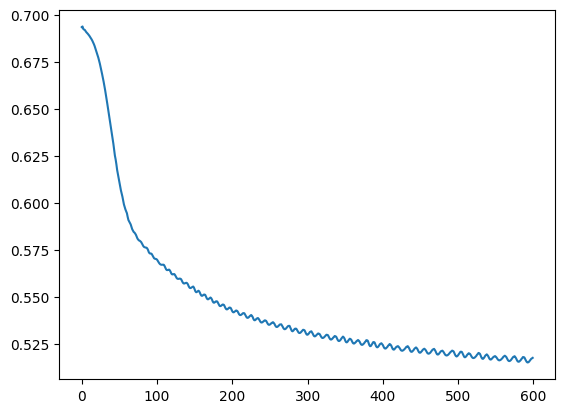

In [243]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [244]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (predictions == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')
    # print confusion matrix
    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test_tensor, predictions))


Accuracy: 0.7346
Confusion Matrix:
 [[26514 15691]
 [ 6748 35585]]


In [245]:
#save model to /model

torch.save(model.state_dict(), '/Users/gioelemonopoli/Documents/hack/Brainwave-Bandits/BrainwaveBandits.WinerR/mlbackend/model/model.pth')

### contrastive learning

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Assuming `combined_df` is your DataFrame with 'Harmonize' (Food Description) and wine features
wine_features = combined_df[['Type', 'Elaborate', 'Body', 'Acidity', 'ABV']].values

# Normalize the wine features
scaler = StandardScaler()
wine_features = scaler.fit_transform(wine_features)

text_embeddings = np.load('data/text_embeddings.npy')

# Now we have `text_embeddings` and `wine_features` as separate inputs

# Split the data into training and test sets
X_train_text, X_test_text, X_train_wine, X_test_wine, y_train, y_test = train_test_split(
    text_embeddings, wine_features, combined_df['pairing'], test_size=0.2, random_state=42,shuffle=True)

# Convert data to PyTorch tensors
X_train_text_tensor = torch.tensor(X_train_text, dtype=torch.float32)
X_train_wine_tensor = torch.tensor(X_train_wine, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# You would also prepare the test tensors in the same way
X_test_text_tensor = torch.tensor(X_test_text, dtype=torch.float32)
X_test_wine_tensor = torch.tensor(X_test_wine, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim,dropout=0.2):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class ContrastiveModel(nn.Module):
    def __init__(self, text_projection_head, wine_projection_head):
        super(ContrastiveModel, self).__init__()
        self.text_projection_head = text_projection_head
        self.wine_projection_head = wine_projection_head

    def forward(self, text_embedding, wine_input):
        # Pass text embeddings through the text projection head
        food_embedding = self.text_projection_head(text_embedding)

        # Pass wine features through the wine projection head
        wine_embedding = self.wine_projection_head(wine_input)
        
        # Compute cosine similarity
        similarity = F.cosine_similarity(food_embedding, wine_embedding, dim=1)
        return similarity

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity, label):
        label = label.squeeze()
        print("Positive similarity mean:", similarity[label == 1].mean().item())
        print("Negative similarity mean:", similarity[label == 0].mean().item())
        # Positive pairs should have similarity close to 1
        pos_loss = (1 - similarity) * label
        
        # Negative pairs should have similarity close to 0 or less than margin
        neg_loss = F.relu(similarity - self.margin) * (1 - label)
        print("Positive loss mean:", pos_loss.mean().item())
        print("Negative loss mean:", neg_loss.mean().item())
        
        # Combine losses
        loss = pos_loss.mean() + neg_loss.mean()
        #loss = 0.5 * pos_loss.mean() + 1.5 * neg_loss.mean()
        return loss



In [ ]:
# Example dimensions
text_embedding_dim = 384
wine_embedding_dim = 5  # Example input dimension for wine
projection_dim = 1024  # Dimension to which embeddings will be projected

# Initialize models
text_projection_head = ProjectionHead(embedding_dim=text_embedding_dim, projection_dim=projection_dim)
wine_projection_head = ProjectionHead(embedding_dim=wine_embedding_dim, projection_dim=projection_dim)
model = ContrastiveModel(text_projection_head, wine_projection_head)

# Loss and optimizer
criterion = ContrastiveLoss(margin=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Set batch size
batch_size = 256  # Adjust based on your memory and dataset size

# Determine the number of batches
num_batches = len(X_train_text_tensor) // batch_size

num_epochs = 3
losses = []
steps = 0
# Training loop, tqdm
for epoch in range(num_epochs):

    """ if steps > 1000:
        break """
    model.train()
    
    epoch_loss = 0.0
    
    # Shuffle the data at the start of each epoch (optional)
    permutation = torch.randperm(X_train_text_tensor.size()[0])
    X_train_text_tensor = X_train_text_tensor[permutation]
    X_train_wine_tensor = X_train_wine_tensor[permutation]
    y_train_tensor = y_train_tensor[permutation]
    
    for i in tqdm(range(num_batches),total=num_batches):
        
        # Create batches
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        batch_X_text = X_train_text_tensor[start_idx:end_idx]
        
        batch_X_wine = X_train_wine_tensor[start_idx:end_idx]
        batch_y = y_train_tensor[start_idx:end_idx]

        # Forward pass
        similarity = model(batch_X_text, batch_X_wine)
        loss = criterion(similarity, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        losses.append(loss.item())
        steps += 1

        """ if steps > 1000:
            break """

    
    # Print the loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / num_batches:.4f}')


In [ ]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [233]:
from tqdm import tqdm

# Test loop
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
threshold = 0.5  # Adjust the threshold as needed

num_test_batches = len(X_test_text_tensor) // batch_size


with torch.no_grad():  # Disable gradient calculation for testing
    for i in tqdm(range(num_test_batches), total=num_test_batches):
        
        # Create batches
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        batch_X_text = X_test_text_tensor[start_idx:end_idx]
        batch_X_wine = X_test_wine_tensor[start_idx:end_idx]
        batch_y = y_test_tensor[start_idx:end_idx]
        
        # Forward pass
        similarity = model(batch_X_text, batch_X_wine)
        loss = criterion(similarity, batch_y)
        
        test_loss += loss.item()

        batch_y = batch_y.squeeze(1)  # This will make batch_y shape [256]

        # Apply threshold to similarity to get predictions
        predicted = (similarity >= threshold).float()
        
        # Calculate accuracy: correct predictions divided by total predictions
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

# Calculate average loss and accuracy
average_test_loss = test_loss / num_test_batches
accuracy = correct / total

# Print the results
print(f'Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.4f}')


 26%|██▌       | 85/330 [00:00<00:00, 426.95it/s]

Positive similarity mean: 0.8354385495185852
Negative similarity mean: 0.4355548024177551
Positive loss mean: 0.08613763749599457
Negative loss mean: 0.2237648218870163
Positive similarity mean: 0.8230441212654114
Negative similarity mean: 0.4888809621334076
Positive loss mean: 0.0857129767537117
Negative loss mean: 0.2652973234653473
Positive similarity mean: 0.880196213722229
Negative similarity mean: 0.4592832326889038
Positive loss mean: 0.0599018856883049
Negative loss mean: 0.24460461735725403
Positive similarity mean: 0.8086575865745544
Negative similarity mean: 0.4664919078350067
Positive loss mean: 0.09417636692523956
Negative loss mean: 0.25460582971572876
Positive similarity mean: 0.8389385342597961
Negative similarity mean: 0.5312001705169678
Positive loss mean: 0.0754975825548172
Negative loss mean: 0.29372018575668335
Positive similarity mean: 0.828246533870697
Negative similarity mean: 0.4912249743938446
Positive loss mean: 0.08856040239334106
Negative loss mean: 0.25149

 39%|███▉      | 128/330 [00:00<00:00, 399.65it/s]

Positive similarity mean: 0.8426262736320496
Negative similarity mean: 0.5045866966247559
Positive loss mean: 0.08299005031585693
Negative loss mean: 0.2510795295238495
Positive similarity mean: 0.8042410612106323
Negative similarity mean: 0.5073191523551941
Positive loss mean: 0.11011438816785812
Negative loss mean: 0.23507747054100037
Positive similarity mean: 0.7949197292327881
Negative similarity mean: 0.4519844949245453
Positive loss mean: 0.09372807294130325
Negative loss mean: 0.26130303740501404
Positive similarity mean: 0.824112057685852
Negative similarity mean: 0.4189653992652893
Positive loss mean: 0.0762639045715332
Negative loss mean: 0.2509883940219879
Positive similarity mean: 0.8418560028076172
Negative similarity mean: 0.5580211281776428
Positive loss mean: 0.07968972623348236
Negative loss mean: 0.2877514362335205
Positive similarity mean: 0.8635780215263367
Negative similarity mean: 0.44631585478782654
Positive loss mean: 0.07034260034561157
Negative loss mean: 0.22

 67%|██████▋   | 221/330 [00:00<00:00, 436.96it/s]

Positive similarity mean: 0.7789681553840637
Negative similarity mean: 0.4597480893135071
Positive loss mean: 0.11224273592233658
Negative loss mean: 0.2425503432750702
Positive similarity mean: 0.8593587875366211
Negative similarity mean: 0.44361141324043274
Positive loss mean: 0.07691320776939392
Negative loss mean: 0.21291984617710114
Positive similarity mean: 0.762859046459198
Negative similarity mean: 0.4342186450958252
Positive loss mean: 0.11671781539916992
Negative loss mean: 0.23977130651474
Positive similarity mean: 0.865969181060791
Negative similarity mean: 0.4599086046218872
Positive loss mean: 0.06753896176815033
Negative loss mean: 0.2411797046661377
Positive similarity mean: 0.7998627424240112
Negative similarity mean: 0.46014127135276794
Positive loss mean: 0.10397754609584808
Negative loss mean: 0.2375296950340271
Positive similarity mean: 0.7946739792823792
Negative similarity mean: 0.5096153020858765
Positive loss mean: 0.09865275025367737
Negative loss mean: 0.2769

100%|██████████| 330/330 [00:00<00:00, 425.71it/s]

Positive similarity mean: 0.846086323261261
Negative similarity mean: 0.4847847819328308
Positive loss mean: 0.08597521483898163
Negative loss mean: 0.22829216718673706
Positive similarity mean: 0.8399059176445007
Negative similarity mean: 0.3494550883769989
Positive loss mean: 0.08817682415246964
Negative loss mean: 0.17498397827148438
Positive similarity mean: 0.8489322662353516
Negative similarity mean: 0.4351396858692169
Positive loss mean: 0.07907451689243317
Negative loss mean: 0.22048689424991608
Positive similarity mean: 0.8569515347480774
Negative similarity mean: 0.46701809763908386
Positive loss mean: 0.06873030960559845
Negative loss mean: 0.26039010286331177
Positive similarity mean: 0.8455838561058044
Negative similarity mean: 0.46987050771713257
Positive loss mean: 0.07238255441188812
Negative loss mean: 0.2673521339893341
Positive similarity mean: 0.8107692003250122
Negative similarity mean: 0.3752313554286957
Positive loss mean: 0.09313701093196869
Negative loss mean: 